In [1]:
import sys
import numpy as np
import tensorflow.keras as keras
from PIL import Image
from matplotlib import pyplot as plt
import pandas as pd
from tqdm import tqdm
import os
import imgaug as ia
from imgaug import augmenters as iaa
import cv2

# Variables

In [2]:
BATCH_SIZE = 64
IMG_SIZE = 192
NUM_CLASSES = 28
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 4)
DATADIR = "C:/Users/antho/RNA/Kaggle/Human-protein-classification"
THRESHOLD = 0.05
VAL_RATIO = 0.1
EPOCHS = 40

# Do not combien cache and multiprocessing
USE_CACHE = True
USE_MULTIPROCESSING = False
WORKERS = 1

# Get Data

In [3]:
def getTrainDataset():
    
    path_to_train = DATADIR + '/train/'
    data = pd.read_csv('train.csv')
    
    paths = []
    labels = []
    
    for name, lbl in zip(data['Id'], data['Target'].str.split(' ')):
        y = np.zeros(28)
        for key in lbl:
            y[int(key)] = 1
        paths.append(os.path.join(path_to_train, name))
        labels.append(y)
        
    return np.array(paths), np.array(labels)

def getTestDataset():

    path_to_test = DATADIR + '/test/'
    data = pd.read_csv('sample_submission.csv')
    
    paths = []
    labels = []
    
    for name in data['Id']:
        y = np.zeros(28)
        paths.append(os.path.join(path_to_test, name))
        labels.append(y)
        
    return np.array(paths), np.array(labels)

# Data Generator

In [4]:
# credits: https://github.com/keras-team/keras/blob/master/keras/utils/data_utils.py#L302
# credits: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

class ProteinDataGenerator(keras.utils.Sequence):
            
    def __init__(self, paths, labels, batch_size, shape, shuffle = False, use_cache = False, augment = False):
        self.paths, self.labels = paths, labels
        self.batch_size = batch_size
        self.shape = shape
        self.shuffle = shuffle
        self.use_cache = use_cache
        self.augment = augment
        if use_cache == True:
            self.cache = np.zeros((paths.shape[0], shape[0], shape[1], shape[2]), dtype=np.float16)
            self.is_cached = np.zeros((paths.shape[0]))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size : (idx+1) * self.batch_size]

        paths = self.paths[indexes]
        X = np.zeros((paths.shape[0], self.shape[0], self.shape[1], self.shape[2]))
        # Generate data
        if self.use_cache == True:
            X = self.cache[indexes]
            for i, path in enumerate(paths[np.where(self.is_cached[indexes] == 0)]):
                image = self.__load_image(path)
                self.is_cached[indexes[i]] = 1
                self.cache[indexes[i]] = image
                X[i] = image
        else:
            for i, path in enumerate(paths):
                X[i] = self.__load_image(path)

        y = self.labels[indexes]
                
        if self.augment == True:
            seq = iaa.Sequential([
                iaa.OneOf([
                    iaa.Fliplr(0.5), # horizontal flips
                    iaa.Crop(percent=(0, 0.1)), # random crops
                    # Small gaussian blur with random sigma between 0 and 0.5.
                    # But we only blur about 50% of all images.
                    iaa.Sometimes(0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    # Strengthen or weaken the contrast in each image.
                    iaa.ContrastNormalization((0.75, 1.5)),
                    # Add gaussian noise.
                    # For 50% of all images, we sample the noise once per pixel.
                    # For the other 50% of all images, we sample the noise per pixel AND
                    # channel. This can change the color (not only brightness) of the
                    # pixels.
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    # Make some images brighter and some darker.
                    # In 20% of all cases, we sample the multiplier once per channel,
                    # which can end up changing the color of the images.
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    # Apply affine transformations to each image.
                    # Scale/zoom them, translate/move them, rotate them and shear them.
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                        rotate=(-180, 180),
                        shear=(-8, 8)
                    )
                ])], random_order=True)

            X = np.concatenate((X, seq.augment_images(X), seq.augment_images(X), seq.augment_images(X)), 0)
            y = np.concatenate((y, y, y, y), 0)
        
        return X, y
    
    def on_epoch_end(self):
        
        # Updates indexes after each epoch
        self.indexes = np.arange(len(self.paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __iter__(self):
        """Create a generator that iterate over the Sequence."""
        for item in (self[i] for i in range(len(self))):
            yield item
            
    def __load_image(self, path):
        R = Image.open(path + '_red.png')
        G = Image.open(path + '_green.png')
        B = Image.open(path + '_blue.png')
        Y = Image.open(path + '_yellow.png')

        im = np.stack((
            np.array(R), 
            np.array(G), 
            np.array(B),
            np.array(Y)), -1)
        
        im = cv2.resize(im, (IMG_SIZE, IMG_SIZE))
        im = np.divide(im, 255)
        return im

# Keras

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input, Conv2D, MaxPooling2D, BatchNormalization, Concatenate, ReLU, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import backend as K
import tensorflow.keras as keras
import tensorflow as tf

### F1

In [6]:
# credits: https://www.kaggle.com/guglielmocamporese/macro-f1-score-keras

def f1(y_true, y_pred):
    #y_pred = K.round(y_pred)
    y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), THRESHOLD), K.floatx())
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    #y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), THRESHOLD), K.floatx())
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1-K.mean(f1)

### Model

In [7]:
def create_model(input_shape):

    model = Sequential()

    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())

    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(BatchNormalization())
    
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())


    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(NUM_CLASSES, activation='sigmoid'))
    
    return model

In [8]:
model = create_model(INPUT_SHAPE)

model.compile(
    loss='binary_crossentropy',
    optimizer=SGD(),
    metrics=['acc', f1])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 190, 190, 64)      2368      
_________________________________________________________________
batch_normalization (BatchNo (None, 190, 190, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 95, 95, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 95, 95, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 93, 93, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 93, 93, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 46, 64)        0

In [9]:
paths, labels = getTrainDataset()

keys = np.arange(paths.shape[0], dtype=np.int)
np.random.shuffle(keys)
lastTrainIndex = int((1-VAL_RATIO)*paths.shape[0])

pathsTrain = paths[0:lastTrainIndex]
labelsTrain = labels[0:lastTrainIndex]
pathsVal = paths[lastTrainIndex:]
labelsVal = labels[lastTrainIndex:]

print(paths.shape, labels.shape)
print(pathsTrain.shape, labelsTrain.shape, pathsVal.shape, labelsTrain.shape)

tg = ProteinDataGenerator(pathsTrain, labelsTrain, BATCH_SIZE, INPUT_SHAPE, use_cache=USE_CACHE, augment=False, shuffle=False)
vg = ProteinDataGenerator(pathsVal, labelsVal, BATCH_SIZE, INPUT_SHAPE, use_cache=USE_CACHE, augment=False, shuffle=False)

checkpoint = ModelCheckpoint(DATADIR, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min', period=1)
reduceLROnPlato = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='min')

(31072,) (31072, 28)
(27964,) (27964, 28) (3108,) (27964, 28)


In [10]:
hist = model.fit_generator(
    tg,
    steps_per_epoch=len(tg),
    validation_data=vg,
    validation_steps=8,
    epochs=EPOCHS,
    use_multiprocessing=USE_MULTIPROCESSING,
    workers=WORKERS,
    verbose=1)

model.save('model.h5')

Epoch 1/40
27964/192 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Epoch 3/40
27964/192 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Epoch 5/40
27964/192 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Epoch 7/40
27964/192 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Epoch 9/40
27964/192 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Epoch 11/40
27964/192 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Epoch 13/40
27964/192 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Epoch 15/40
27964/192 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Epoch 17/40
27964/192 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Epoch 19/40
27964/192 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Epoch 21/40
27964/192 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Epoch 23/40
27964/192 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Epoch 25/40
27964/192 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Epoch 27/40
27964/192 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Epoch 29/40
27964/192 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Epoch 31/40
27964/192 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Epoch 33/40
27964/192 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Epoch 35/40
27964/192 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Epoch 37/40
27964/192 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Epoch 39/40
27964/192 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

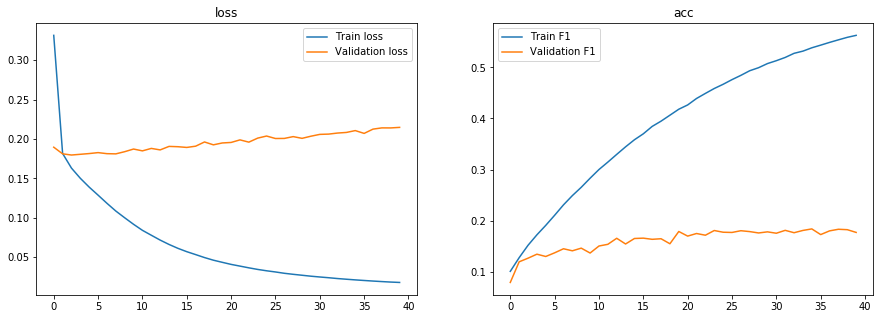

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('loss')
ax[0].plot(hist.epoch, hist.history["loss"], label="Train loss")
ax[0].plot(hist.epoch, hist.history["val_loss"], label="Validation loss")
ax[1].set_title('acc')
ax[1].plot(hist.epoch, hist.history["f1"], label="Train F1")
ax[1].plot(hist.epoch, hist.history["val_f1"], label="Validation F1")
ax[0].legend()
ax[1].legend()

# Full validation

In [12]:
fullValGen = vg

lastFullValPred = np.empty((0,28))
lastFullValLabels = np.empty((0,28))
for i in tqdm(range(len(fullValGen))):
    im, lbl = fullValGen[i]
    scores = model.predict(im)
    lastFullValPred = np.append(lastFullValPred, scores, axis=0)
    lastFullValLabels = np.append(lastFullValLabels, lbl, axis=0)
    
print(lastFullValPred.shape, lastFullValLabels.shape)

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:51<00:00,  1.05s/it]

(3108, 28) (3108, 28)


In [13]:
from sklearn.metrics import f1_score as off1

rng = np.arange(0, 1, 0.001)
f1s = np.zeros((rng.shape[0], 28))
for j, t in enumerate(tqdm(rng)):
    for i in range(28):
        p = np.array(lastFullValPred[:,i]>t, dtype=np.int8)
        scoref1 = off1(lastFullValLabels[:, i], p, average='binary')
        f1s[j,i] = scoref1

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]C:\Users\antho\Anaconda3\envs\ML\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
  1%|▌                                                                                | 7/1000 [00:01<07:21,  2.25it/s]C:\Users\antho\Anaconda3\envs\ML\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:34<00:00, 29.00it/s]


In [14]:
print('Individual F1-scores for each class:')
print(np.max(f1s, axis=0))
print('Macro F1-score CV =', np.mean(np.max(f1s, axis=0)))

Individual F1-scores for each class:
[0.70580158 0.19494585 0.26548673 0.17010309 0.36512262 0.22246696
 0.19       0.19924812 0.2        0.5        0.5        0.15384615
 0.18309859 0.28571429 0.68341709 0.0012945  0.10752688 0.30769231
 0.17431193 0.16851441 0.42857143 0.47139588 0.13265306 0.3296
 0.14285714 0.54046763 0.0990099  0.        ]
Macro F1-score CV = 0.2758266473682449


Probability threshold maximizing CV F1-score for each class:
[0.239 0.089 0.044 0.05  0.087 0.035 0.09  0.044 0.039 0.03  0.024 0.041
 0.076 0.113 0.075 0.    0.044 0.048 0.046 0.043 0.054 0.285 0.054 0.103
 0.019 0.135 0.023 0.   ]


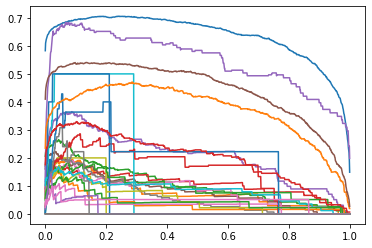

In [15]:
plt.plot(rng, f1s)
T = np.empty(28)
for i in range(28):
    T[i] = rng[np.where(f1s[:,i] == np.max(f1s[:,i]))[0][0]]
print('Probability threshold maximizing CV F1-score for each class:')
print(T)

# Submission

In [16]:
pathsTest, labelsTest = getTestDataset()

testg = ProteinDataGenerator(pathsTest, labelsTest, BATCH_SIZE, INPUT_SHAPE)
submit = pd.read_csv('sample_submission.csv')
P = np.zeros((pathsTest.shape[0],28))
for i in tqdm(range(len(testg))):
    images, labels = testg[i]
    score = model.predict(images)
    P[i*BATCH_SIZE:i*BATCH_SIZE+score.shape[0]] = score

100%|████████████████████████████████████████████████████████████████████████████████| 183/183 [04:10<00:00,  1.37s/it]


In [17]:
PP = np.array(P)

In [18]:
prediction = []

for row in tqdm(range(submit.shape[0])):
    
    str_label = ''
    
    for col in range(PP.shape[1]):
        if(PP[row, col] < T[col]):
            str_label += ''
        else:
            str_label += str(col) + ' '
    prediction.append(str_label.strip())
    
submit['Predicted'] = np.array(prediction)
submit.to_csv('submission.csv', index=False)

100%|█████████████████████████████████████████████████████████████████████████| 11702/11702 [00:00<00:00, 65173.55it/s]
